<a href="https://www.kaggle.com/code/lonnieqin/ubiquant-market-prediction-with-dnn?scriptVersionId=114140474" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

#  Ubiquant Market Prediction with DNN
In this notebook, I will build a Ubiquant Market Prediction Model with TensorFlow DNN. 
I will train the Model using CombinatorialPurgedGroupKFold CV strategy. You can find more detials in this [discussion](https://www.kaggle.com/c/ubiquant-market-prediction/discussion/305118).
In other to train the Model for 5 folds in a single run and avoid OOM error, I made a TF-record dataset in notebook [UMP TF-Record: CombinatorialPurgedGroupKFold](https://www.kaggle.com/lonnieqin/ump-tf-record-combinatorialpurgedgroupkfold).
## Import Packages

In [1]:
import os
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from scipy import stats
from tensorflow.python.ops import math_ops
from tensorflow.python.keras import backend as K

## Configuration

In [2]:
class Config:
    is_training = False
    tf_record_dataset_path = "../input/ump-combinatorialpurgedgroupkfold-tf-record/"
    output_dataset_path = "../input/ubiquant-market-prediction-with-dnn-output/"
config = Config()

## Create an IntegerLookup layer for investment_id input

In [3]:
%%time
investment_ids = pd.read_csv("../input/ump-combinatorialpurgedgroupkfold-tf-record/investment_ids.csv")
investment_id_size = len(investment_ids) + 1
with tf.device("cpu"):
    investment_id_lookup_layer = layers.IntegerLookup(max_tokens=investment_id_size)
    investment_id_lookup_layer.adapt(investment_ids)

2022-12-18 12:21:11.026546: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-18 12:21:11.107523: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-18 12:21:11.108326: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-18 12:21:11.110388: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

CPU times: user 600 ms, sys: 399 ms, total: 998 ms
Wall time: 2.38 s


## Make Tensorflow dataset

In [4]:
def decode_function(record_bytes):
  return tf.io.parse_single_example(
      # Data
      record_bytes,
      # Schema
      {
          "features": tf.io.FixedLenFeature([300], dtype=tf.float32),
          "time_id": tf.io.FixedLenFeature([], dtype=tf.int64),
          "investment_id": tf.io.FixedLenFeature([], dtype=tf.int64),
          "target": tf.io.FixedLenFeature([], dtype=tf.float32)
      }
  )
def preprocess(item):
    return (item["investment_id"], item["features"]), item["target"]
def make_dataset(file_paths, batch_size=4096, mode="train"):
    ds = tf.data.TFRecordDataset(file_paths)
    ds = ds.map(decode_function)
    if mode != "train":
        time_ids = ds.map(lambda item: item["time_id"])
        time_ids = time_ids.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if mode == "train":
        ds = ds.shuffle(batch_size * 4) 
    ds = ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    if mode == "train":
        return ds
    else:
        return ds, time_ids

## Modeling

In [5]:
def correlation(x, y, axis=-2):
    """Metric returning the Pearson correlation coefficient of two tensors over some axis, default -2."""
    x = tf.convert_to_tensor(x)
    y = math_ops.cast(y, x.dtype)
    n = tf.cast(tf.shape(x)[axis], x.dtype)
    xsum = tf.reduce_sum(x, axis=axis)
    ysum = tf.reduce_sum(y, axis=axis)
    xmean = xsum / n
    ymean = ysum / n
    xvar = tf.reduce_sum( tf.math.squared_difference(x, xmean), axis=axis)
    yvar = tf.reduce_sum( tf.math.squared_difference(y, ymean), axis=axis)
    cov = tf.reduce_sum( (x - xmean) * (y - ymean), axis=axis)
    corr = cov / tf.sqrt(xvar * yvar)
    return tf.constant(1.0, dtype=x.dtype) - corr

def get_model():
    investment_id_inputs = tf.keras.Input((1, ), dtype=tf.uint16)
    features_inputs = tf.keras.Input((300, ), dtype=tf.float16)
    
    investment_id_x = investment_id_lookup_layer(investment_id_inputs)
    investment_id_x = layers.Embedding(investment_id_size, 32, input_length=1)(investment_id_x)
    investment_id_x = layers.Reshape((-1, ))(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    investment_id_x = layers.Dropout(0.1)(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    investment_id_x = layers.Dropout(0.1)(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    investment_id_x = layers.Dropout(0.1)(investment_id_x)
    
    feature_x = layers.Dense(256, activation='swish')(features_inputs)
    feature_x = layers.Dropout(0.1)(feature_x)
    feature_x = layers.Dense(256, activation='swish')(feature_x)
    feature_x = layers.Dropout(0.1)(feature_x)
    feature_x = layers.Dense(256, activation='swish')(feature_x)
    feature_x = layers.Dropout(0.1)(feature_x)
    
    x = layers.Concatenate(axis=1)([investment_id_x, feature_x])
    x = layers.Dense(512, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(128, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(32, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dropout(0.1)(x)
    output = layers.Dense(1)(x)
    rmse = keras.metrics.RootMeanSquaredError(name="rmse")
    model = tf.keras.Model(inputs=[investment_id_inputs, features_inputs], outputs=[output])
    model.compile(optimizer=tf.optimizers.Adam(0.001), loss='mse', metrics=['mse', "mae", "mape", rmse, correlation])
    return model

Let's take a look at this Model's architecture.

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
integer_lookup (IntegerLookup)  (None, 1)            0           input_1[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 32)        114560      integer_lookup[0][0]             
__________________________________________________________________________________________________
reshape (Reshape)               (None, 32)           0           embedding[0][0]                  
______________________________________________________________________________________________

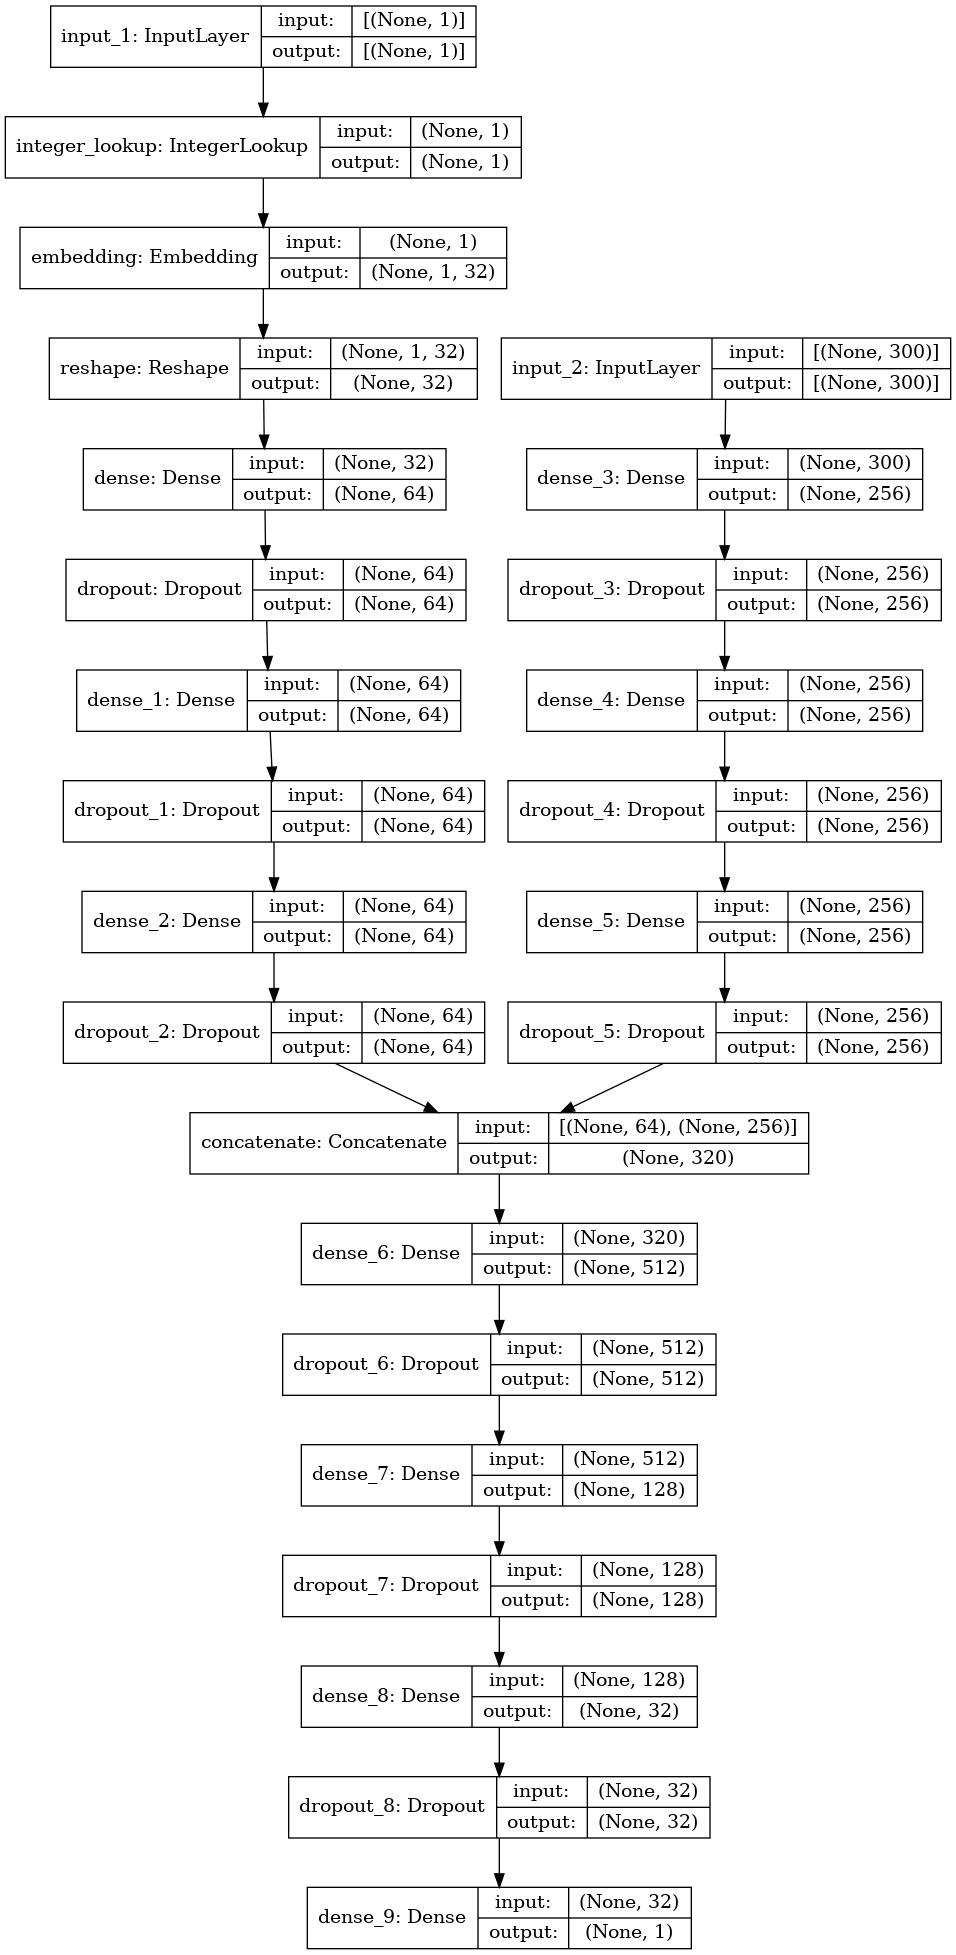

In [6]:
model = get_model()
model.summary()
keras.utils.plot_model(model, show_shapes=True)

## Model Training

In [7]:
%%time
models = []
for i in range(5):
    train_path = f"{config.tf_record_dataset_path}fold_{i}_train.tfrecords"
    valid_path = f"{config.tf_record_dataset_path}fold_{i}_test.tfrecords"
    valid_ds, time_id_ds = make_dataset([valid_path], mode="valid")
    model = get_model()
    if config.is_training:
        train_ds = make_dataset([train_path])
        checkpoint = keras.callbacks.ModelCheckpoint(f"model_{i}.tf", monitor="val_correlation", mode="min", save_best_only=True, save_weights_only=True)
        early_stop = keras.callbacks.EarlyStopping(patience=10)
        history = model.fit(train_ds, epochs=30, validation_data=valid_ds, callbacks=[checkpoint, early_stop])
        model.load_weights(f"model_{i}.tf")
        for metric in ["loss", "mae", "mape", "rmse", "correlation"]:
            pd.DataFrame(history.history, columns=[metric, f"val_{metric}"]).plot()
            plt.title(metric.upper())
            plt.show()
    else:
        model.load_weights(f"{config.output_dataset_path}model_{i}.tf")
    y_vals = []
    time_ids = []
    for (_, y), time_id in zip(valid_ds, time_id_ds):
        y_vals += list(y.numpy().reshape(-1))
        time_ids += list(time_id.numpy().reshape(-1))
    y_pred = model.predict(valid_ds).reshape(-1)
    df = pd.DataFrame({"time_id": time_ids, "y": y_vals, "y_predict": y_pred})
    pearson_score = df.groupby("time_id").apply(lambda item: stats.pearsonr(item.y, item.y_predict)[0]).mean()
    print(f"Pearson Score: {pearson_score}")
    models.append(model)

Pearson Score: 0.09872789552374733
Pearson Score: 0.11747439231208702


2022-12-18 12:23:37.941568: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Pearson Score: 0.10516908683323004


2022-12-18 12:24:36.806437: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Pearson Score: 0.09009513319632888
Pearson Score: 0.1319378467715419
CPU times: user 5min 14s, sys: 2min 31s, total: 7min 45s
Wall time: 4min 30s


## Submission

In [8]:
def preprocess_test(investment_id, feature):
    return (investment_id, feature), 0
def make_test_dataset(feature, investment_id, batch_size=1024):
    ds = tf.data.Dataset.from_tensor_slices(((investment_id, feature)))
    ds = ds.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    return ds
def inference(models, ds):
    y_preds = []
    for model in models:
        y_pred = model.predict(ds)
        y_preds.append(y_pred)
    return np.mean(y_preds, axis=0)

In [9]:
try:
    import ubiquant
    env = ubiquant.make_env()
    iter_test = env.iter_test() 
    features = [f"f_{i}" for i in range(300)]
    for (test_df, sample_prediction_df) in iter_test:
        ds = make_test_dataset(test_df[features], test_df["investment_id"])
        sample_prediction_df['target'] = inference(models, ds)
        env.predict(sample_prediction_df) 
except:
    print("Ubiquant Dataset has been removed.")

Ubiquant Dataset has been removed.
